In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.gridspec as gridspec # to do the grid of plots


In [83]:
data = pd.read_csv('Data_train.csv')

In [3]:
data.head(5)

,CLIENTE,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X79,X80,X81,X82,X83,X84,X85,X86,X87,y
0,C_26572,2,3,3,15.652542,8.294133,7.358409,10.203390,3,4,...,0,No,No,No,951,79,872,89.0,10.0,0
1,C_47823,1,1,1,6.779661,1.288000,5.491661,6.779661,1,2,...,1,No,No,No,628,54,574,628.0,574.0,1
2,C_28925,7,49,51,319.355932,120.441150,198.914782,233.584746,4,7,...,1,No,No,No,969,9,960,35.0,26.0,0
3,C_74142,12,68,86,3153.338983,2171.714952,981.624031,1633.932203,14,90,...,1,No,Si,No,968,5,963,8.0,3.0,0
4,C_32527,12,39,41,370.423729,163.928936,206.494793,270.118644,3,41,...,0,No,Si,No,943,4,939,6.0,2.0,0


In [4]:
print(f'Cantidad de observaciones: {data.shape[0]}')
print(f'Cantidad de columnas: {data.shape[1]}')

Cantidad de observaciones: 57631
Cantidad de columnas: 90


In [5]:
print('Cantidad de variables númericas : {} '.format(data.select_dtypes(['int64','float64']).shape[1]))
print('Cantidad de variables object : {} '.format(data.select_dtypes(['object']).shape[1]))

Cantidad de variables númericas : 85 
Cantidad de variables object : 5 


- Existen missing values?

In [6]:
data.isna().sum().sort_values(ascending = False).to_frame()[0:10].rename(columns = {0:"Cantidad de missings"})

,Cantidad de missings
X18,16426
X19,14989
X21,10585
X78,4522
X6,2374
X87,1287
X86,1287
X10,3
X73,1
CLIENTE,0


- Existe 9 variables con missing values. Hay que conocer cuanto equivale esos missings values en relación al total de observaciones

In [7]:
pd.options.display.float_format = "{:,.2f}".format
data.isna().sum().sort_values(ascending = False).to_frame()[0:10].rename(columns = {0:"Porcentaje(%) de missings"})/data.shape[0]*100

,Porcentaje(%) de missings
X18,28.50
X19,26.01
X21,18.37
X78,7.85
X6,4.12
X87,2.23
X86,2.23
X10,0.01
X73,0.00
CLIENTE,0.00


- La variable X18, es la que tiene mayor cantidad de nulos llegan a cubrir el 28.5% del total de observaciones, seguida de la variable X19, con 26.01%
- Podemos ver que ante los elevados porcentajes de missings, eliminaremos las variables X18, X19 y X21, ya que el imputarlas puede generar cambios en su distribución y sesgos más adelante en el análisis.
- Ahora es necesario saber si estás variables con missings values son de tipo numéricas o de clasificación

In [84]:
data.drop(columns = ['X18', 'X19', 'X21'], axis= 1,inplace = True)

In [9]:
data.isna().sum().sort_values(ascending = False)[0:6].index

Index(['X78', 'X6', 'X87', 'X86', 'X10', 'X73'], dtype='object')

## Imputación de missings
En el caso de clientes, los outliers no los eliminaremos ya que al no conocer el nombre de las variables, el eliminar valores podría hacernos perder información de clientes además de que se estandarizará los datos posteriormente.
\
Variables de imputar:
- X78
- X6
- X87
- X86
- X10

In [10]:
def distri(col):
    media = data[col].mean().round(2)
    mediana = data[col].median()
    maximo = data[col].max()
    iqr = 1.5 * (np.percentile(data[col], 75) - np.percentile(data[col], 25))
    upper = iqr + np.percentile(data[col], 75)
    lower = np.percentile(data[col], 25).round(0) - iqr
    minimo = data[col].min()
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(x =data[col], ax=ax_box)
    sns.histplot(data[col], ax=ax_hist, kde = True)
    ax_hist.axvline(x=media, color='b', linestyle='--', label='Media:{}'.format(media))
    ax_hist.axvline(x=mediana, color='g', linestyle='-.', label='Mediana:{}'.format(mediana))
    #plt.axvline(x=lower, color='yellow', linestyle='-', label='Lower IQR:{}'.format(lower))
    #plt.axvline(x=upper, color='yellow', linestyle='-', label='UpperIQR:{}'.format(upper))
    plt.legend()

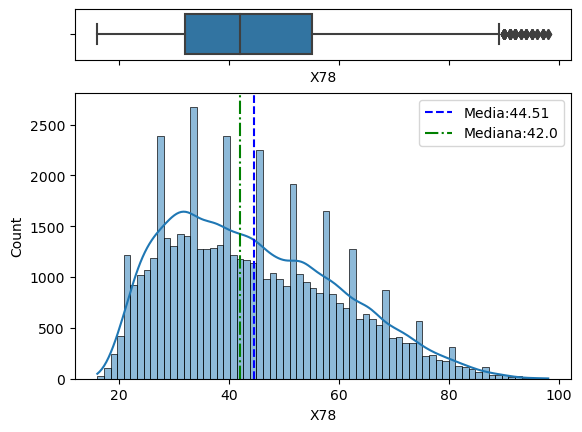

In [11]:
#X78
distri('X78')

- El promedio y la mediana se encuentran muy cerca lo cual es favorable. No imputaremos con la media o la mediana, si no con una muestra de la variable para no cambiar la distribución de la variable
- Los outliers no conocemos su origen, de que si son un error en la carga de la data o si es un comportamiento real de los usuariros. Por ese motivo no los trataré en esta oportunidad.

In [85]:
def resample_fillna(col):
    data[col][data[col].isnull()] = data[col].dropna().sample(data[col].isnull().sum()).values

In [86]:
for i in ['X78', 'X6', 'X87', 'X86', 'X10', 'X73']:
    resample_fillna(i)
    

In [15]:
data.isna().sum().sort_values(ascending = False).to_frame()[0:10].rename(columns = {0:"Cantidad de missings"})

,Cantidad de missings
CLIENTE,0
X57,0
X65,0
X64,0
X63,0
X62,0
X61,0
X60,0
X59,0
X58,0


- Nos encargamos de los missings values

## Análisis exploratorio

In [87]:
data.select_dtypes(include = 'object').drop(columns = 'CLIENTE',axis = 1).columns


Index(['X73', 'X80', 'X81', 'X82'], dtype='object')

In [88]:
data.describe(include =['float64','int64'])

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X76,X77,X78,X79,X83,X84,X85,X86,X87,y
count,57631.000000,57631.000000,57631.000000,57631.000000,57631.000000,57631.000000,57631.000000,57631.000000,57631.000000,57631.000000,...,57631.000000,57631.000000,57631.000000,57631.000000,57631.000000,57631.000000,57631.000000,57631.000000,57631.000000,57631.000000
mean,6.667818,16.354046,18.941264,508.318895,368.905277,139.413618,224.482906,5.477174,21.045132,4.197428,...,2.803456,15.879128,44.520241,0.436293,807.250299,25.865073,781.385227,85.053513,59.446496,0.039215
std,3.482593,19.445707,26.049948,1789.764362,1900.248349,336.134824,401.713232,4.523484,23.164210,4.994055,...,7.646060,22.980328,15.479816,0.495929,243.842956,24.251161,248.604442,115.402868,107.607873,0.194108
min,1.000000,1.000000,1.000000,0.000000,0.000000,-50594.186518,-20.898305,1.000000,1.000000,0.000000,...,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,4.000000,5.000000,5.000000,79.347458,44.782105,22.397722,37.457627,2.000000,7.000000,1.000000,...,0.000000,4.000000,32.000000,0.000000,765.000000,6.000000,734.000000,21.000000,7.000000,0.000000
50%,7.000000,10.000000,11.000000,213.322034,132.218850,66.882873,103.432203,4.000000,14.000000,3.000000,...,0.000000,9.000000,42.000000,0.000000,925.000000,18.000000,892.000000,47.000000,20.000000,0.000000
75%,10.000000,21.000000,23.000000,539.838983,358.588167,164.026174,251.478814,7.000000,27.000000,5.000000,...,2.000000,19.000000,55.000000,1.000000,961.000000,40.000000,941.000000,99.000000,60.000000,0.000000
max,12.000000,352.000000,1370.000000,354363.977458,404958.163976,11445.036601,16820.932203,56.000000,912.000000,74.000000,...,244.000000,1062.000000,98.000000,1.000000,972.000000,91.000000,972.000000,972.000000,959.000000,1.000000


In [50]:
data.drop(columns = 'CLIENTE',axis = 1).select_dtypes(include = 'category').columns


Index(['X73', 'X80', 'X81', 'X82'], dtype='object')

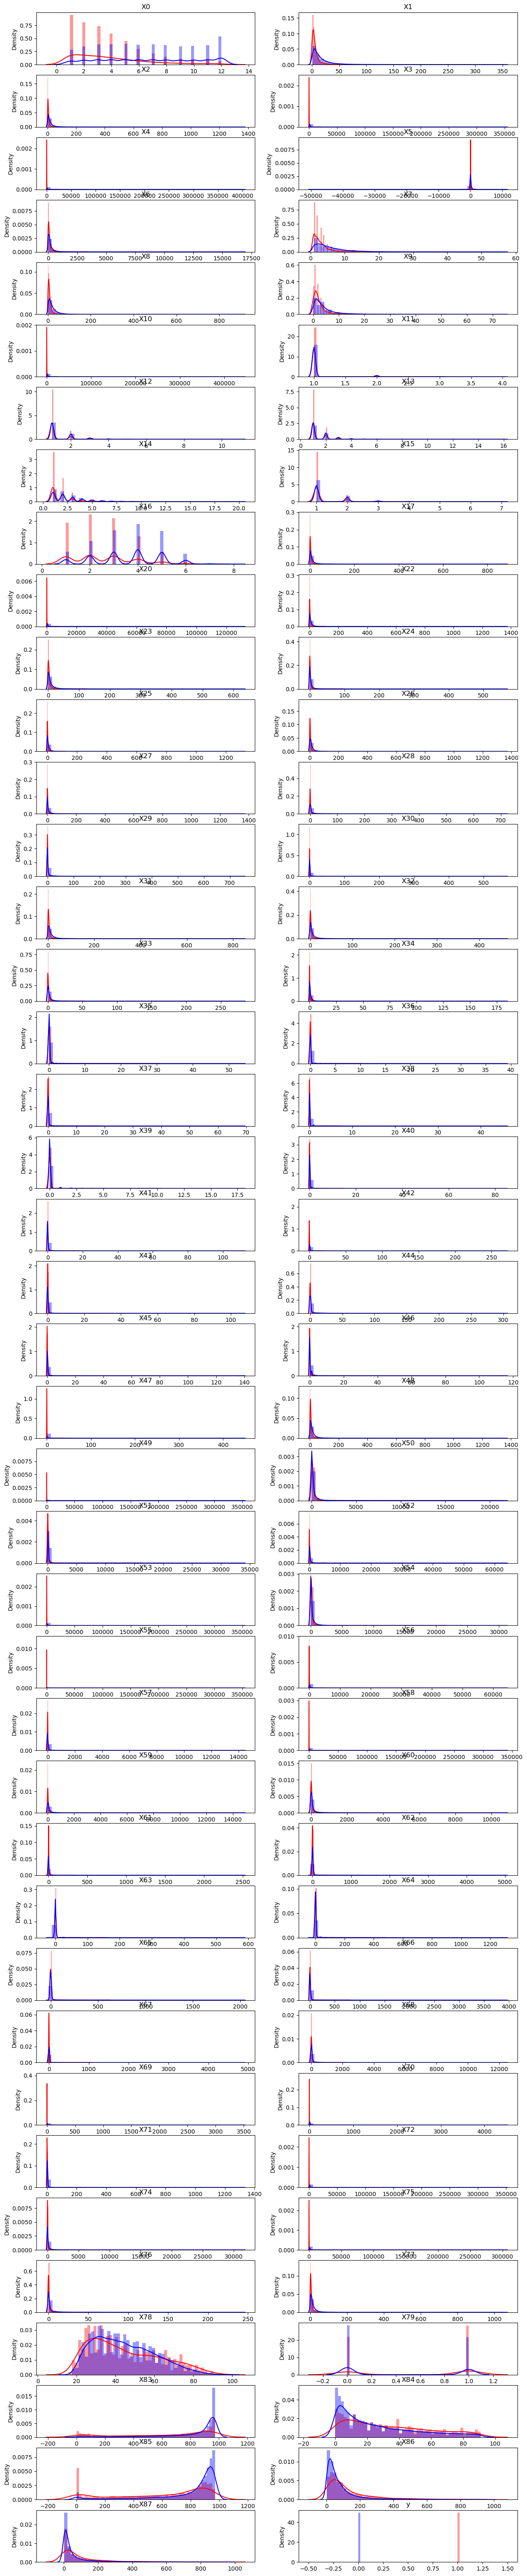

In [19]:
columns = data.select_dtypes(include = ['int64','float64']).columns


grid = gridspec.GridSpec(41, 2)
plt.figure(figsize=(15,20*4))

for n, col in enumerate(data[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(data[col][data.y == 1], bins = 50, color='r') 
    sns.distplot(data[col][data.y == 0], bins = 50, color='b')
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
plt.show()

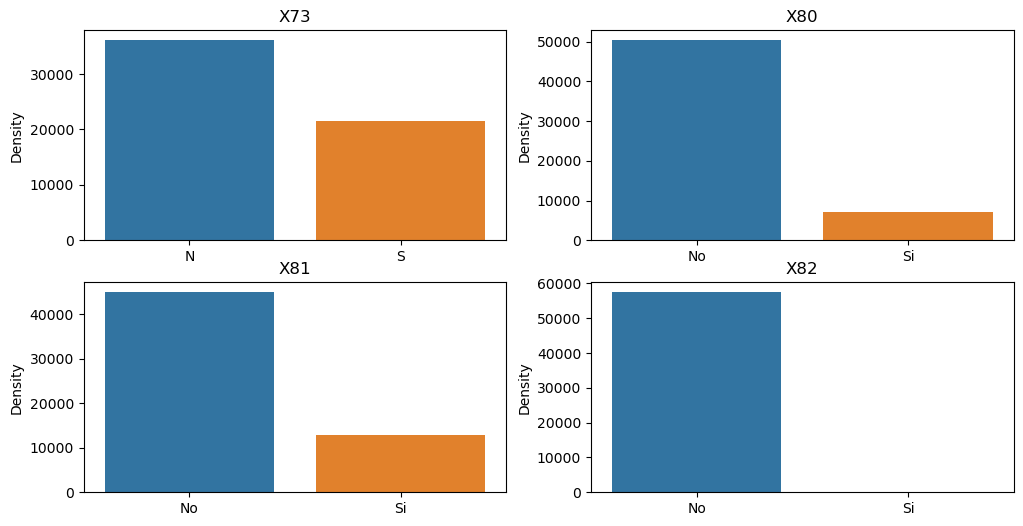

In [90]:
columns = data.drop(columns = 'CLIENTE',axis = 1).select_dtypes(include = 'object').columns


grid = gridspec.GridSpec(2 ,2)
plt.figure(figsize=(12,6))

for n, col in enumerate(data[columns]):
    ax = plt.subplot(grid[n])
    sns.countplot(x = data[col] ) #Will receive the "semi-salmon" violin
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
plt.show()

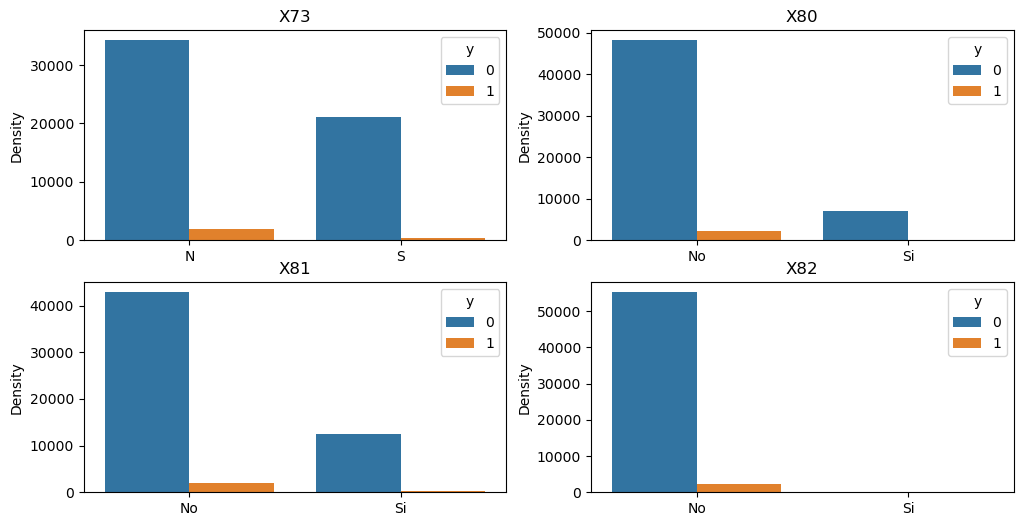

In [91]:
columns = data.drop(columns = 'CLIENTE',axis = 1).select_dtypes(include = 'object').columns


grid = gridspec.GridSpec(2 ,2)
plt.figure(figsize=(12,6))

for n, col in enumerate(data[columns]):
    ax = plt.subplot(grid[n])
    sns.countplot(x = data[col] , hue = data.y) #Will receive the "semi-salmon" violin
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
plt.show()

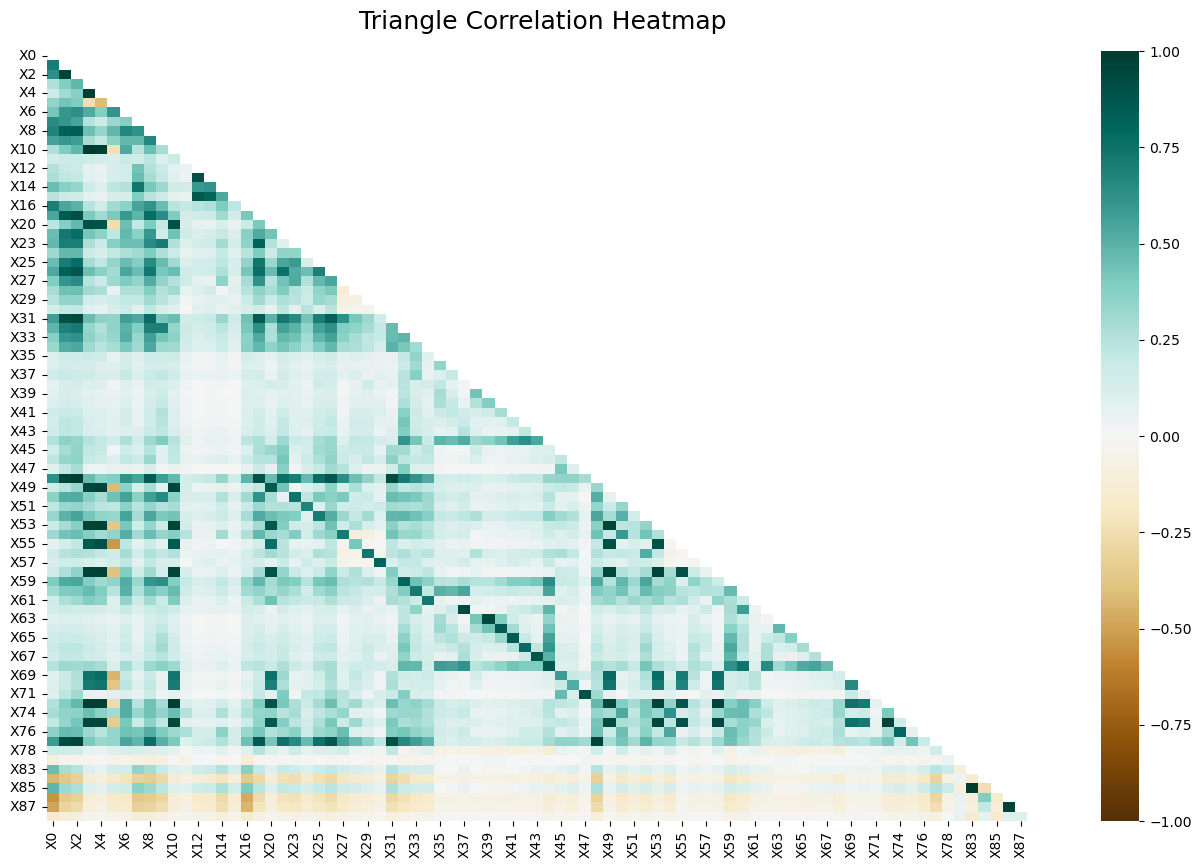

In [22]:
plt.figure(figsize=(16, 10))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))
heatmap = sns.heatmap(data.corr(), mask=mask, vmin=-1, vmax=1, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

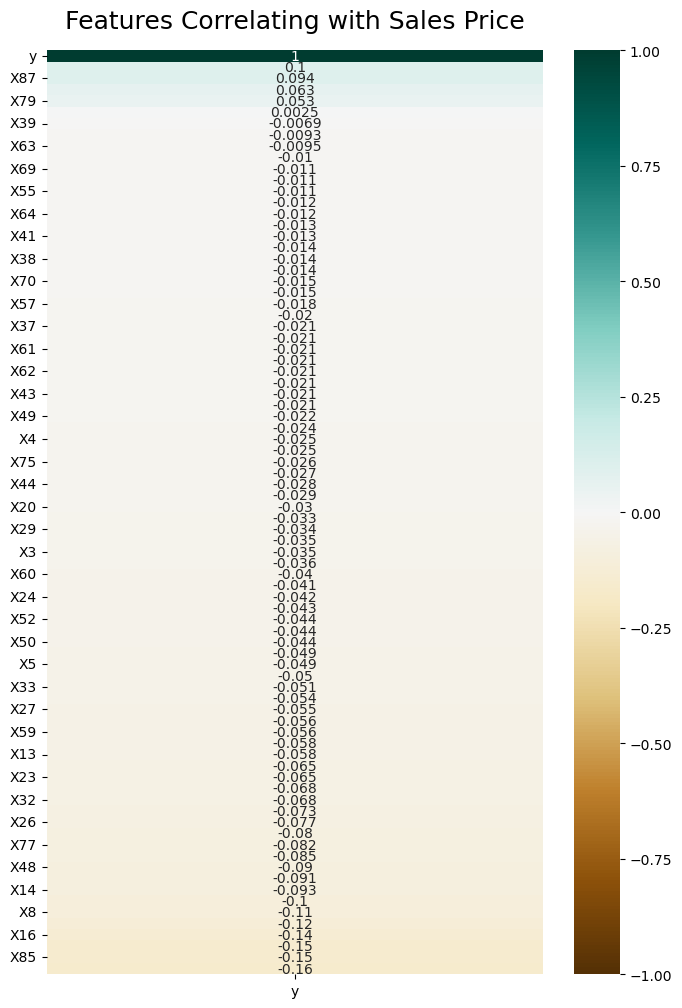

In [23]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(data.corr()[['y']].sort_values(by='y', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Sales Price', fontdict={'fontsize':18}, pad=16);

In [92]:
data['X73'] = data.X73.apply(lambda x: 0 if x == 'N' else 1 )
data['X80'] = data.X80.apply(lambda x: 0 if x == 'No' else 1 )
data['X81'] = data.X81.apply(lambda x: 0 if x == 'No' else 1 )
data['X82'] = data.X82.apply(lambda x: 0 if x == 'No' else 1 )

---
## Modeling

In [74]:
from sklearn.decomposition import PCA
#scaler = StandardScaler()
X = data.drop(columns = ['y','CLIENTE'], axis = 1)
y = data.y



In [101]:
# Removing correlated features
corr_matrix = data.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find features with correlation greater than 0.5
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]


In [103]:
data = data.drop(to_drop, axis=1)

In [104]:
data.shape

(57631, 57)

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

#from imblearn.over_sampling import SMOTE
#metrics
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,make_scorer
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score,recall_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, recall_score

#from sklearn.metrics import plot_confusion_matrix

In [105]:
#scaler = StandardScaler()
X = data.drop(columns = ['y','CLIENTE'], axis = 1)
y = data.y

#X = scaler.fit_transform(X)


In [106]:
X_train, X_test, y_train,y_test = train_test_split(X,y , test_size=0.3, stratify=y)
print(f'tamaño del train: {X_train.shape[0]}')
print(f'tamaño del test: {X_test.shape[0]}')

tamaño del train: 40341
tamaño del test: 17290


### Logistic regression

In [31]:
params= {'C': [0.01,0.1,1.0,10],   'solver':['newton-cg','liblinear'],
            'penalty': ['none','l1','l2',]}
scoring = make_scorer(recall_score)
lm = LogisticRegression(random_state=0)
grid = GridSearchCV(lm, params, cv = 5, scoring = scoring)

grid.fit(X,y)


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [0.01, 0.1, 1.0, 10],
                         'penalty': ['none', 'l1', 'l2'],
                         'solver': ['newton-cg', 'liblinear']},
             scoring=make_scorer(recall_score))

In [32]:
lg_precission=[]
lg_recall = []
lg_f1=[]

    # Initiate the model
lm = LogisticRegression(random_state = 0 ,**grid.best_params_)
# Fit the model
lm_model = lm.fit(X_train, y_train)
# Make Predictions
lm_pred= lm_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score

lm_precision = precision_score(y_test, lm_pred)
lg_precission.append(lm_precision)#append
    
lm_recall = recall_score(y_test, lm_pred)
lg_recall.append(lm_recall)#append
    
lm_f1 = 2 * (lm_precision * lm_recall) / (lm_precision + lm_recall)
lg_f1.append(lm_f1)#append
 
df_lg_sin_smote = pd.DataFrame({'Precission':lg_precission,'Recall':lg_recall,'F1_score':lg_f1},index=['Logistico'])
df_lg_sin_smote.T

,Logistico
Precission,0.00
Recall,0.00
F1_score,NaN


### SVM

In [33]:
from sklearn.svm import SVC
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(random_state=0), param_grid, scoring = scoring, cv =5)
  
# fitting the model for grid search
grid.fit(X, y)

In [ ]:
svm_precission=[]
svm_recall = []
svm_f1=[]

    # Initiate the model
svm = SVC(random_state=0)
# Fit the model
svm_model = svm.fit(X_train, y_train)
# Make Predictions
svm_pred= svm_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score

svm_precision = precision_score(y_test, svm_pred)
svm_precission.append(svm_precision)#append
    
svm_recall = recall_score(y_test, svm_pred)
svm_recall.append(svm_recall)#append
    
svm_f1 = 2 * (svm_precision * svm_recall) / (svm_precision + svm_recall)
svm_f1.append(svm_f1)#append
 
df_svm_sin_smote = pd.DataFrame({'Precission':svm_precission,'Recall':svm_recall,'F1_score':svm_f1},index=['SVM'])
df_svm_sin_smote.T

### Random forest

In [19]:
rf_params = {'criterion':['gini','entropy'],
            'max_depth' : [3,5,10],
            'n_estimators': [100,200],
            'max_features' : ["auto", "sqrt", "log2"]}
scoring = make_scorer(recall_score)

grid_rf =GridSearchCV(RandomForestClassifier(random_state=0), rf_params, cv= 5, scoring = scoring)
grid_rf.fit(X, y)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200]},
             scoring=make_scorer(recall_score))

In [22]:

rf_precission=[]
rf_recall = []
rf_f1=[]


    # Initiate the model
rfc = RandomForestClassifier(random_state=2, **grid_rf.best_params_)
    
# Fit the model
rfc_model = rfc.fit(X_train, y_train)
# Make Predictions
rfc_pred= rfc_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score

rfc_precision = precision_score(y_test, rfc_pred)
rf_precission.append(rfc_precision)#append
    
rfc_recall = recall_score(y_test, rfc_pred)
rf_recall.append(rfc_recall)#append
    
rfc_f1 = 2 * (rfc_precision * rfc_recall) / (rfc_precision + rfc_recall)
rf_f1.append(rfc_f1)#append
    

#dataframe de los scores
df_rfc_sin_smote = pd.DataFrame({'Precission':rf_precission,'Recall':rf_recall,'F1_score':rf_f1},index=['Random Forest'])
df_rfc_sin_smote.T

,Random Forest
Precission,0.0
Recall,0.0
F1_score,NaN


### XGBOOST

In [98]:
scale_pos_weight = sqrt(np.count_nonzero(y_train_smote == 0) / np.count_nonzero(y_train_smote))


In [108]:
model = xgb.XGBClassifier(random_state=0)
scale_pos_weight = sqrt(np.count_nonzero(y_train_smote == 0) / np.count_nonzero(y_train_smote))

# Definir parámetros a ajustar en la búsqueda de grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
    "scale_pos_weight": [scale_pos_weight],
    'booster': ['gbtree']
}

# Realizar búsqueda de grid con validación cruzada (5 folds)
grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=5)

# Entrenar el modelo con el conjunto de datos completo (sin split train/test)
grid_search.fit(X_train_smote, y_train_smote)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Evaluar el rendimiento del modelo con validación cruzada (10 folds)
scores = cross_val_score(grid_search.best_estimator_, X, y, scoring='roc_auc', cv=10)

# Calcular el promedio y la desviación estándar del AUC-ROC en las 10 folds
print("AUC-ROC promedio con validación cruzada (10 folds): {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))


[07:49:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:49:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:49:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:49:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [43]:
xgb_precission=[]
xgb_recall = []
xgb_f1=[]


    # Initiate the model
xgbc = xgb.XGBClassifier(random_state=0, **grid_search.best_params_)
    
# Fit the model
xgbc_model = xgbc.fit(X_train, y_train)
# Make Predictions
xgbc_pred= xgbc_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score

xgbc_precision = precision_score(y_test, xgbc_pred)
xgb_precission.append(xgbc_precision)#append
    
xgbc_recall = recall_score(y_test, xgbc_pred)
xgb_recall.append(xgbc_recall)#append
    
xgbc_f1 = 2 * (xgbc_precision * xgbc_recall) / (xgbc_precision + xgbc_recall)
xgb_f1.append(xgbc_f1)#append
    

#dataframe de los scores
df_xgbc_sin_smote = pd.DataFrame({'Precission':xgb_precission,'Recall':xgb_recall,'F1_score':xgb_f1},index=['XGBOOST'])
df_xgbc_sin_smote.T

[06:22:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,XGBOOST
Precission,0.122449
Recall,0.008850
F1_score,0.016506


In [44]:

print(classification_report(y_test, xgbc_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     16612
           1       0.12      0.01      0.02       678

    accuracy                           0.96     17290
   macro avg       0.54      0.50      0.50     17290
weighted avg       0.93      0.96      0.94     17290



In [107]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
counter = Counter(y_train)
print(counter)

st = RandomOverSampler(random_state = 0, sampling_strategy = 0.33)
X_train_smote, y_train_smote = st.fit_resample (X_train, y_train)

counter = Counter(y_train_smote)
print(counter)



Counter({0: 38759, 1: 1582})
Counter({0: 38759, 1: 12790})


In [40]:
xgb_precission=[]
xgb_recall = []
xgb_f1=[]


    # Initiate the model
xgbc = xgb.XGBClassifier(random_state=0, **grid_search.best_params_)
    
# Fit the model
xgbc_model = xgbc.fit(X_train_smote, y_train_smote)
# Make Predictions
xgbc_pred= xgbc_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score

xgbc_precision = precision_score(y_test, xgbc_pred)
xgb_precission.append(xgbc_precision)#append
    
xgbc_recall = recall_score(y_test, xgbc_pred)
xgb_recall.append(xgbc_recall)#append
    
xgbc_f1 = 2 * (xgbc_precision * xgbc_recall) / (xgbc_precision + xgbc_recall)
xgb_f1.append(xgbc_f1)#append
    

#dataframe de los scores
df_xgbc_sin_smote = pd.DataFrame({'Precission':xgb_precission,'Recall':xgb_recall,'F1_score':xgb_f1},index=['XGBOOST'])
df_xgbc_sin_smote.T

[05:42:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,XGBOOST
Precission,0.089286
Recall,0.081121
F1_score,0.085008


In [41]:
print(classification_report(y_test, xgbc_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     16612
           1       0.09      0.08      0.09       678

    accuracy                           0.93     17290
   macro avg       0.53      0.52      0.52     17290
weighted avg       0.93      0.93      0.93     17290

